# Retail Lab (Generalized Linear Models-Continuous Data)

**Learning Objectives:**
  * Define and fit generalized linear models for continuous data
  * Gain exposure to retail related DataSets

## Context of the dataset

### 1. There are three datasets: `articles.csv.zip`, `customers.csv.zip` and `transactions2020.csv.zip`

#### 2. The Articles dataset contains information over products available.
#### 3. The Customers dataset contains information over registered customers.
#### 4. The Transactions dataset contains purchases of articles made by customers.


## 1. Library Import

In [1]:
!pip install linearmodels
!pip install wooldridge

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 22.6 MB/s eta 0:00:00


In [2]:
import wooldridge as woo
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import linearmodels as plm
import numpy as np
from scipy import stats
import warnings

In [3]:
warnings.simplefilter('ignore')

## 2. Data loading and DataFrame creation

In [4]:
Articles=pd.read_csv("https://github.com/thousandoaks/Python4DS-I/raw/main/datasets/articles.csv.zip")

In [5]:
Customers=pd.read_csv("https://github.com/thousandoaks/Python4DS-I/raw/main/datasets/customers.csv.zip")

In [6]:
Transactions=pd.read_csv("https://github.com/thousandoaks/Python4DS-I/raw/main/datasets/transactions2020.csv.zip")

In [7]:
## we merge both DataFrames using the common key: article_id. We store the result in a new DataFrame
TransactionsAndArticles=pd.merge(Transactions, Articles, how='left',on='article_id')

In [8]:
## we merge both DataFrames using the common key: customer_id. We store the result in a new DataFrame
TransactionsAndArticlesAndCustomers=pd.merge(TransactionsAndArticles, Customers, how='left',on='customer_id')

In [10]:
TransactionsAndArticlesAndCustomers.head(2).T

,0,1
t_dat,2020-06-01,2020-06-01
customer_id,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,000b31552d3785c79833262bbeefa484cbc43d7b612b3c...
article_id,844198001,777016001
price,0.016932,0.030492
sales_channel_id,2,1
product_code,844198,777016
prod_name,Saturn trs (J),Cisco skirt
product_type_no,296,275
product_type_name,Pyjama bottom,Skirt
product_group_name,Nightwear,Garment Lower body


## 3. What drives Sales ?
### We want to explore the impact of club_member_status, age, sales_channel_id and fashion_news_frequency on purchases made by customers.

In [18]:
TransactionsAndArticlesAndCustomers[['customer_id','club_member_status','fashion_news_frequency','age','price','sales_channel_id']].head()

,customer_id,club_member_status,fashion_news_frequency,age,price,sales_channel_id
0,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,ACTIVE,NONE,40.0,0.016932,2
1,000b31552d3785c79833262bbeefa484cbc43d7b612b3c...,ACTIVE,Regularly,59.0,0.030492,1
2,002d8d26c9414c981c012c6f5e4b2de7ffd3bc568c4574...,ACTIVE,NONE,23.0,0.010153,2
3,002d8d26c9414c981c012c6f5e4b2de7ffd3bc568c4574...,ACTIVE,NONE,23.0,0.016932,2
4,002d8d26c9414c981c012c6f5e4b2de7ffd3bc568c4574...,ACTIVE,NONE,23.0,0.025407,2


In [19]:
## We compute total Purchases by customers
TransactionsAndArticlesAndCustomersGroupedByCustomerID=TransactionsAndArticlesAndCustomers.groupby(['customer_id','club_member_status','fashion_news_frequency','sales_channel_id']).agg({'price':'sum','age':'mean'}).reset_index()
TransactionsAndArticlesAndCustomersGroupedByCustomerID.rename(columns={'price':'TotalPurchases'},inplace=True)
TransactionsAndArticlesAndCustomersGroupedByCustomerID

,customer_id,club_member_status,fashion_news_frequency,sales_channel_id,TotalPurchases,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,ACTIVE,NONE,1,0.050831,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,ACTIVE,NONE,1,0.027102,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,ACTIVE,NONE,2,0.061000,24.0
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,ACTIVE,Regularly,2,0.255814,52.0
4,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,ACTIVE,NONE,2,0.076237,20.0
...,...,...,...,...,...,...
732858,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,ACTIVE,NONE,2,0.247288,24.0
732859,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,ACTIVE,NONE,1,0.104949,21.0
732860,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,ACTIVE,Regularly,1,0.064339,21.0
732861,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,ACTIVE,Regularly,2,0.077864,21.0


In [21]:
TransactionsAndArticlesAndCustomersGroupedByCustomerID.describe()

,sales_channel_id,TotalPurchases,age
count,732863.00000,732863.000000,729287.000000
mean,1.56452,0.184044,34.855017
std,0.49582,0.270994,13.775434
min,1.00000,0.000559,16.000000
25%,1.00000,0.050814,24.000000
50%,2.00000,0.101661,30.000000
75%,2.00000,0.211695,47.000000
max,2.00000,18.905441,99.000000


In [28]:
TransactionsAndArticlesAndCustomersGroupedByCustomerID.groupby(['club_member_status','fashion_news_frequency','sales_channel_id']).count()

customer_id  \
club_member_status fashion_news_frequency sales_channel_id                
ACTIVE             Monthly                1                         181   
                                          2                          19   
                   NONE                   1                      174950   
                                          2                      230428   
                   Regularly              1                      143852   
                                          2                      169835   
LEFT CLUB          NONE                   1                          11   
                                          2                          70   
PRE-CREATE         NONE                   1                         128   
                                          2                       12366   
                   Regularly              1                          25   
                                          2                         998   

                                                            TotalPurchases  \
club_member_status fashion_news_frequency sales_channel_id                   
ACTIVE             Monthly                1                            181   
                                          2                             19   
                   NONE                   1                         174950   
                                          2                         230428   
                   Regularly              1                         143852   
                                          2                         169835   
LEFT CLUB          NONE                   1                             11   
                                          2                             70   
PRE-CREATE         NONE                   1                            128   
                                          2                          12366   
                   Regularly              1                             25   
                                          2                            998   

                                                               age  
club_member_status fashion_news_frequency sales_channel_id          
ACTIVE             Monthly                1                    180  
                                          2                     19  
                   NONE                   1                 173586  
                                          2                 229802  
                   Regularly              1                 143475  
                                          2                 169545  
LEFT CLUB          NONE                   1                     11  
                                          2                     70  
PRE-CREATE         NONE                   1                    121  
                                          2                  11481  
                   Regularly              1                     24  
                                          2                    973

We will remove observations having club_member_status=='LEFT CLUB' given their low numbers


We will remove observations having club_member_status=='ACTIVE' AND fashion_news_frequency=='Monthly' given their low numbers

customer_id  \
club_member_status fashion_news_frequency sales_channel_id                
ACTIVE             NONE                   1                      174950   
                                          2                      230428   
                   Regularly              1                      143852   
                                          2                      169835   
PRE-CREATE         NONE                   1                         128   
                                          2                       12366   
                   Regularly              1                          25   
                                          2                         998   

                                                            TotalPurchases  \
club_member_status fashion_news_frequency sales_channel_id                   
ACTIVE             NONE                   1                         174950   
                                          2                         230428   
                   Regularly              1                         143852   
                                          2                         169835   
PRE-CREATE         NONE                   1                            128   
                                          2                          12366   
                   Regularly              1                             25   
                                          2                            998   

                                                               age  
club_member_status fashion_news_frequency sales_channel_id          
ACTIVE             NONE                   1                 173586  
                                          2                 229802  
                   Regularly              1                 143475  
                                          2                 169545  
PRE-CREATE         NONE                   1                    121  
                                          2                  11481  
                   Regularly              1                     24  
                                          2                    973

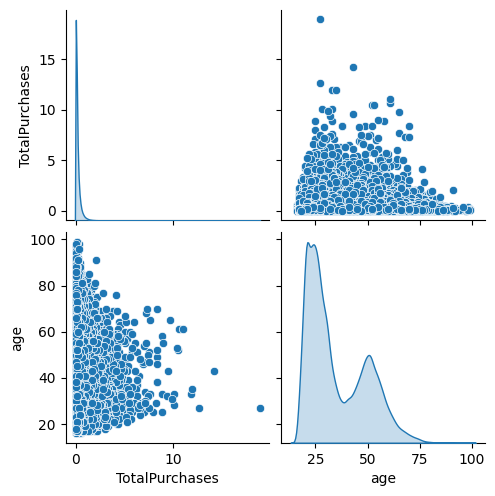

In [16]:
  sns.pairplot(data=TransactionsAndArticlesAndCustomersGroupedByCustomerID,diag_kind='kde')

In [17]:
TransactionsAndArticlesAndCustomersGroupedByCustomerID[['TotalPurchases',	'age']].corr()

,TotalPurchases,age
TotalPurchases,1.000000,0.020276
age,0.020276,1.000000


### Based on the correlation analysis we observe no correlation between age and totalpurchases

## 4. The model


#### We will assume that the random variable TotalPurchases follows a normal distribution with mean $µ_i$ and variance $\sigma^2$, that is:

$TotalPurchases\sim N(\mu_i,\sigma^2)$


#### We further assume that the expected value $µ_i$ is a linear function of  one continuous factors age . We also incorporate several discrete factors:  sales_channel_id, club_member_status,	fashion_news_frequency, that is:

$ \mu_i=\beta_1*age+\delta_1*saleschannelid+\delta_2*clubmemberstatus+\delta_3*fashionnewsfrequency $


## 5. Estimation of the parameters
#### We rely on our old friend OLS to fit the model as the response variable is continuous and we are assuming a normal distribution.
#### We remove categories with low observations

In [37]:
LeftClubFilter=TransactionsAndArticlesAndCustomersGroupedByCustomerID['club_member_status']!='LEFT CLUB'
MonthlyFilter=(TransactionsAndArticlesAndCustomersGroupedByCustomerID['fashion_news_frequency']!='Monthly')
TransactionsAndArticlesAndCustomersGroupedByCustomerID[LeftClubFilter & MonthlyFilter].groupby(['club_member_status','fashion_news_frequency','sales_channel_id']).count()

customer_id  \
club_member_status fashion_news_frequency sales_channel_id                
ACTIVE             NONE                   1                      174950   
                                          2                      230428   
                   Regularly              1                      143852   
                                          2                      169835   
PRE-CREATE         NONE                   1                         128   
                                          2                       12366   
                   Regularly              1                          25   
                                          2                         998   

                                                            TotalPurchases  \
club_member_status fashion_news_frequency sales_channel_id                   
ACTIVE             NONE                   1                         174950   
                                          2                         230428   
                   Regularly              1                         143852   
                                          2                         169835   
PRE-CREATE         NONE                   1                            128   
                                          2                          12366   
                   Regularly              1                             25   
                                          2                            998   

                                                               age  
club_member_status fashion_news_frequency sales_channel_id          
ACTIVE             NONE                   1                 173586  
                                          2                 229802  
                   Regularly              1                 143475  
                                          2                 169545  
PRE-CREATE         NONE                   1                    121  
                                          2                  11481  
                   Regularly              1                     24  
                                          2                    973

In [35]:
reg = smf.ols(formula='TotalPurchases ~ age+sales_channel_id+fashion_news_frequency+club_member_status ', data=TransactionsAndArticlesAndCustomersGroupedByCustomerID[LeftClubFilter & MonthlyFilter])



# We fit the model
results = reg.fit()

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         TotalPurchases   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     9278.
Date:                Tue, 01 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:38:32   Log-Likelihood:                -65642.
No. Observations:              729007   AIC:                         1.313e+05
Df Residuals:                  729002   BIC:                         1.314e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.0267      0.001    -20.309      0.000      -0.029      -0.024
fashion_news_frequency[T.Regularly]     0.0147      0.001     23.395      0.000       0.014       0.016
club_member_status[T.PRE-CREATE]       -0.1027      0.002    -42.646      0.000      -0.107      -0.098
age                                     0.0006   2.26e-05     26.692      0.000       0.001       0.001
sales_channel_id                        0.1185      0.001    188.183      0.000       0.117       0.120
==============================================================================
Omnibus:                   991806.263   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        745395482.419
Skew:                           7.437   Prob(JB):                         0.00
Kurtosis:                     158.943   Cond. No.                         292.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### We have fit the following model:

$ \mu_i=-0.026+0.0006*age+0.00147*fashionnewsfrequency-0.1027*clubmemberstatus+0.1158*saleschannelid $




## 6. Model interpretation:


#### We find that, on average, the mean of TotalPurchases increases  0.0006  for each additional additional year of age. Being a regular consumer of fashion news frequency increments TotalPurchases by 0.0147. TotalPurchases in sales channel 2 are 0.1185 larger than those in channel 1.

#### We also observe that customers not being members of the club yet purchases 0.10 less than those already in the club.


#### All coefficients are statistically significant.

#### The model is able to explain only 5% of the total variability (R-sqared=0.048).
#### In spite of the model not being good at predicting customer purchases it serves the purposes of determining which sales channel is better as well as the impact of club membership and fashion news.



## 7. Regression Diagnostics

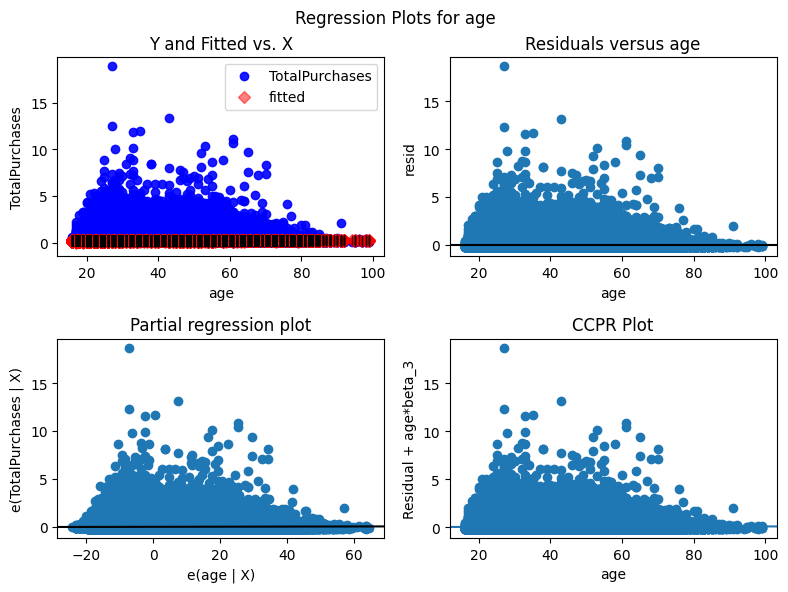

In [38]:
fig = plt.figure(figsize=(8, 6))
sm.graphics.plot_regress_exog(results, 'age', fig=fig)
plt.show()

Based on the plots we conclude that there is heteroskedasticity in our model. This would require factor rescaling as well as the incorporation of aditional factors into our model.

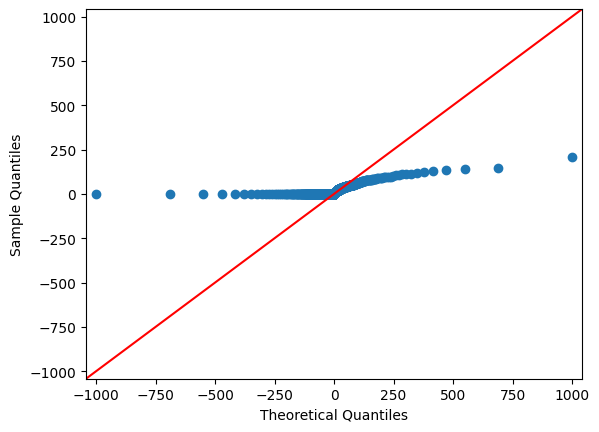

In [40]:
residuals = results.resid # residuals
fig = sm.qqplot(residuals,stats.t, fit=True, line="45")
plt.show()

#### Based on the previous Q-Q plot we conclude that we have evidence against the assumption of normally distributed residuals.

#### The present model is not valid as it is.

#### We can further test the normality assumption by way of the Jarque-Bera test. The Jarque-Bera test statistic tests the null that the data is normally distributed against an alternative that the data follow some other distribution.

#### The Jarque-Bera test statistic is always positive, and if it is not close to zero, it shows that the sample data do not have a normal distribution. Based on the results below (J-B test: 61.04) we find no evidence against the normality assumption of residuals.

In [41]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(results.resid)
lzip(name, test)

[('Jarque-Bera', 745395482.4189358),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 7.436991101780673),
 ('Kurtosis', 158.943252462406)]